## Redrock zscan ##

Stephen Bailey, 15 January 2017

This notebook documents the scaling performance of
`redrock.zscan.parallel_calc_zchi2_targets()`, which fits
target spectra to a redshifted 5-component PCA template to map
the best fit $\chi^2$ vs. redshift.  It uses a combination of
  * numba/LLVM JIT compiled python code for resampling and trapezoidal integration;
    prior to numba this was by far the slowest component
  * numpy vector operations
  * 5x5 MKL matrix solution per target per sampled redshift for PCA model fit
  * miscellaneous python

`zscan` is parallelized with python `multiprocessing` within a single node.
The processes are data parallel, i.e. they do not communicate with each other.

The plot below shows the rate of
target redshifts processed per second vs. number of processes used.  For Haswell tests,
`$OMP_NUM_THREADS = $MKL_NUM_THREADS = 64 // numprocesses`,
while for KNL tests these were set to either `272 // numprocesses` (corresponding to the
number of hyperthreading cores) or `68 // numprocesses` (corresponding to the number of physical cores).  Compared to real data, these tests used spectra with fewer wavelength samples and tested fewer redshifts in order to have the tests quickly.

Initial observations:
  * The Haswell node was 75x faster than the KNL node (!)
  * Haswell had ok but not great scaling performance with more processes
    (note that this is a log plot).  However, the largest concurrencies ran in less than a
    second so they may have been dominated by startup/teardown overheads.
  * KNL had no improvement with more processes; I hope this is just some parameter
    that I'm missing and that I accidentally wasn't actually using more physical cores
  * Using fewer OMP/MKL threads per process gave modestly better performance on KNL
    (a separate ad hoc Haswell test not documented here showed similar results there)

Code versions used (as reported by "git describe"):
  * [redrock](https://github.com/sbailey/redrock) 0.2-35-g3addbf9
  * [knltest](https://github.com/sbailey/knltest) 0.1 script `rrscan.py`.
  * NERSC installed python/3.5-anaconda

In [1]:
%pylab inline
import numpy as np
import io

Populating the interactive namespace from numpy and matplotlib


In [2]:
#- Datasets from running "python rrzscan.py [haswell|knl]
hswdata = '''\
ncpu nthread  time    rate
  1     64    4.74    1055.49
  2     32    3.21    1556.29
  4     16    1.49    3351.20
  8      8    1.04    4786.74
 16      4    0.72    6923.60
 32      2    0.48    10412.14
 64      1    0.46    10914.74
'''

knldata272 = '''\
ncpu nthread  time    rate
  4     68    42.73    117.01
  8     34    40.08    124.74
 16     17    38.29    130.59
 32      8    42.92    116.49
 64      4    38.48    129.93
128      2    45.27    110.45
'''

knldata68 = '''\
ncpu nthread  time    rate
  4     17    34.60    144.51
  8      8    35.54    140.68
 16      4    34.00    147.08
 32      2    38.74    129.06
 64      1    34.92    143.20
128      1    39.03    128.09
'''

def parse_data(datastr):
    dtype = [('ncpu', int), ('nthread', int), ('time', float), ('rate', float)]
    data = np.loadtxt(io.StringIO(datastr), skiprows=1, dtype=dtype)
    return data

hsw = parse_data(hswdata)
knl272 = parse_data(knldata272)
knl68 = parse_data(knldata68)

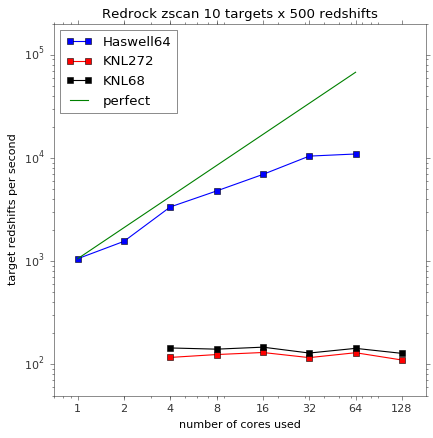

In [3]:
figure(figsize=(6,6))
plot(hsw['ncpu'], hsw['rate'], 'bs-', label='Haswell64')
plot(knl272['ncpu'], knl272['rate'], 'rs-', label='KNL272')
plot(knl68['ncpu'], knl68['rate'], 'ks-', label='KNL68')

plot(hsw['ncpu'], hsw['ncpu']*hsw['rate'][0], 'g-', label='perfect')

loglog()
xticks([1,2,4,8,16,32,64,128], [1,2,4,8,16,32,64,128])
xlim(0.7, 128/0.7)
ylim(50, 2e5)
xlabel('number of cores used')
ylabel('target redshifts per second')
title('Redrock zscan 10 targets x 500 redshifts')
legend(loc='upper left')
savefig('rrzscan.png')


In [4]:
np.max(hsw['rate']) / np.max(knl68['rate'])

74.209545825401136

Full logs cut-and-paste from each run
```
<cori code> python debug.py cori
len(redshifts) = 500
len(template.redshifts) = 20
WARNING: Using 50 cores for 50 redshifts
len(redshifts) = 500
ncpu nthread  time    rate
  1     64    4.74    1055.49
  2     32    3.21    1556.29
  4     16    1.49    3351.20
  8      8    1.04    4786.74
 16      4    0.72    6923.60
 32      2    0.48    10412.14
 64      1    0.46    10914.74

<cori code> python debug.py knlfast
len(redshifts) = 250
len(template.redshifts) = 20
WARNING: Using 25 cores for 25 redshifts
len(redshifts) = 250
ncpu nthread  time    rate
  4     68    10.75    116.29
  8     34    10.62    117.71
 16     17    10.54    118.60
 32      8    11.61    107.70
 64      4    12.06    103.67
128      2    15.89    78.66

#- with nthread = 272 // ncpu
<cori code> python debug.py knl    
len(redshifts) = 500
len(template.redshifts) = 20
WARNING: Using 50 cores for 50 redshifts
len(redshifts) = 500
ncpu nthread  time    rate
  4     68    42.73    117.01
  8     34    40.08    124.74
 16     17    38.29    130.59
 32      8    42.92    116.49
 64      4    38.48    129.93
128      2    45.27    110.45

#- second run iwth nthread = 272 // npu later on
len(redshifts) = 500
len(template.redshifts) = 20
WARNING: Using 50 cores for 50 redshifts
len(redshifts) = 500
ncpu nthread  time    rate
  4     68    42.56    117.49
  8     34    39.34    127.11
 16     17    37.70    132.64
 32      8    42.42    117.88
 64      4    37.10    134.76
128      2    44.61    112.09

#- with nthread = 136 // ncpu
<cori code> python debug.py knl
len(redshifts) = 500
len(template.redshifts) = 20
WARNING: Using 50 cores for 50 redshifts
len(redshifts) = 500
ncpu nthread  time    rate
  4     34    35.76    139.81
  8     17    36.71    136.20
 16      8    38.89    128.56
 32      4    35.89    139.30
 64      2    39.45    126.74
128      1    38.88    128.60


#- with nthread = 68 // ncpu
<cori code> python debug.py knl
len(redshifts) = 500
len(template.redshifts) = 20
WARNING: Using 50 cores for 50 redshifts
len(redshifts) = 500
ncpu nthread  time    rate
  4     17    34.60    144.51
  8      8    35.54    140.68
 16      4    34.00    147.08
 32      2    38.74    129.06
 64      1    34.92    143.20
128      1    39.03    128.09
```

